# Loan Default

## Problem Statement

A key question for many financial institutions is whether an individual or entity will default on a loan. This important question can have wide implications, not just for a single institution, but also for economies as a whole.

This project will look at predicting the probability of default using machine learning methods. 

In [1]:
# Full Module Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import warnings

# Selective imports
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SequentialFeatureSelector   
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from great_tables import GT, md, html

In [2]:
# Program Parameters
rand_state = 0              # Random Seed to ensure reproducibility
sample_frac = .1             # Fraction of data frame for stratified sample (ease development time)
read_models = False         # Should models be read from disk or fit
save_models = True          # Should the models used be save to disk
include_pairplot = False     # Should pairplots be generated
max_iter = 10_000           # Maximum iterations for Stochastic Gradient Descent Convergence

## Data Cleaning

In [3]:
# Import the raw data set and recode names
name_dict = {'ID':'id',
             'Default':'default',
             'Prct_uso_tc':'pct_cc_usage',
             'Edad':'age',
             'Nro_prestao_retrasados':'num_loans_delayed',
             'Prct_deuda_vs_ingresos':'debt_to_income_ratio',
             'Mto_ingreso_mensual':'mthly_inc_amount',
             'Nro_prod_financieros_deuda':'num_loans_and_cc',
             'Nro_retraso_60dias':'num_late_payments',
             'Nro_creditos_hipotecarios':'num_mtg_loans',
             'Nro_retraso_ultm3anios':'pymt_delays',
             'Nro_dependiente':'num_dependents'}

dtype_dict = {'id':'object',
              'default':'bool',
              'pct_cc_usage':'float64',
              'age':'int64',
              'num_loans_delayed':'int64',
              'debt_to_income_ratio':'float64',
              'mthly_inc_amount':'float64',
              'num_loans_and_cc':'int64',
              'num_late_payments':'int64',
              'num_mtg_loans':'int64',
              'pymt_delays':'int64'}

raw_data = (pd.read_csv('data/credit_scoring.csv')
              .rename(columns=name_dict)
              .astype(dtype_dict))

raw_data.dtypes

id                       object
default                    bool
pct_cc_usage            float64
age                       int64
num_loans_delayed         int64
debt_to_income_ratio    float64
mthly_inc_amount        float64
num_loans_and_cc          int64
num_late_payments         int64
num_mtg_loans             int64
pymt_delays               int64
num_dependents          float64
dtype: object

In [4]:
# Create data dictionary for report inclusion
data_dict = pd.DataFrame({'Original Name':[key for key, value in name_dict.items()],
                          'Analysis Name':[value for key, value in name_dict.items()],
                          'Description':['Identifier',
                                         'Client with more than 90 days without paying their loan',
                                         'Percentage of credit card usage in the last month',
                                         'Age',
                                         'Number of loans with payment delays of more than 3 months in the last 3 years',
                                         'Financial debt-to-income ratio',
                                         'Monthly income amount',
                                         'Number of loans (including vehicle or mortgage loans) and number of credit cards last year',
                                         'Number of times the client has been over 60 days late in the last 3 years',
                                         'Number of mortgage loans',
                                         'Number of payment delays over 30 days in the last 3 years',
                                         'Number of dependents']})

(GT(data_dict)
 .tab_header(title='Loan Default Dataset', subtitle='Data Dictionary')
 .tab_source_note(source_note=md('Source: Kaggle - https://www.kaggle.com/datasets/hugoferquiroz/credit-default-only-numbers'))
 .opt_stylize(style=1, color='blue')
).save('assets/data_dictionary.png')

GT(_tbl_data=                 Original Name         Analysis Name  \
0                           ID                    id   
1                      Default               default   
2                  Prct_uso_tc          pct_cc_usage   
3                         Edad                   age   
4       Nro_prestao_retrasados     num_loans_delayed   
5       Prct_deuda_vs_ingresos  debt_to_income_ratio   
6          Mto_ingreso_mensual      mthly_inc_amount   
7   Nro_prod_financieros_deuda      num_loans_and_cc   
8           Nro_retraso_60dias     num_late_payments   
9    Nro_creditos_hipotecarios         num_mtg_loans   
10      Nro_retraso_ultm3anios           pymt_delays   
11             Nro_dependiente        num_dependents   

                                          Description  
0                                          Identifier  
1   Client with more than 90 days without paying t...  
2   Percentage of credit card usage in the last month  
3                                                 Age  
4   Number of loans with payment delays of more th...  
5                      Financial debt-to-income ratio  
6                               Monthly income amount  
7   Number of loans (including vehicle or mortgage...  
8   Number of times the client has been over 60 da...  
9                            Number of mortgage loans  
10  Number of payment delays over 30 days in the l...  
11                               Number of dependents  , _body=<great_tables._gt_data.Body object at 0x72369f714830>, _boxhead=Boxhead([ColInfo(var='Original Name', type=<ColInfoTypeEnum.default: 1>, column_label='Original Name', column_align='left', column_width=None), ColInfo(var='Analysis Name', type=<ColInfoTypeEnum.default: 1>, column_label='Analysis Name', column_align='left', column_width=None), ColInfo(var='Description', type=<ColInfoTypeEnum.default: 1>, column_label='Description', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x72369f714440>, _spanners=Spanners([]), _heading=Heading(title='Loan Default Dataset', subtitle='Data Dictionary', preheader=None), _stubhead=None, _source_notes=[Md(text='Source: Kaggle - https://www.kaggle.com/datasets/hugoferquiroz/credit-default-only-numbers')], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x72369f714c20>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsI

### Stratified Sampling

In [5]:
# This code does a stratified sampling by the target class. This is done only for 
# efficiency purposes in development. For a full production run this should be set
# to 1, so all data is included. However, be prepared as this could take hours to
# run if you are fitting all of the models.
display(raw_data['default'].value_counts())

raw_data = (raw_data.groupby(by=['default'])[list(raw_data.columns)]
                    .apply(lambda x: x.sample(frac = sample_frac, random_state=rand_state))
                    .reset_index(drop=True))

display(raw_data['default'].value_counts())

raw_data.head()


default
False    139974
True      10026
Name: count, dtype: int64

default
False    13997
True      1003
Name: count, dtype: int64

,id,default,pct_cc_usage,age,num_loans_delayed,debt_to_income_ratio,mthly_inc_amount,num_loans_and_cc,num_late_payments,num_mtg_loans,pymt_delays,num_dependents
0,92967,False,0.004900,73,0,0.491189,3120.0,5,0,1,0,0.0
1,126140,False,1.000000,42,0,536.000000,NaN,1,1,0,0,0.0
2,125434,False,0.702353,28,0,0.526746,6000.0,6,0,1,0,1.0
3,29063,False,0.766658,54,0,3019.000000,NaN,4,0,1,0,0.0
4,35748,False,0.038827,50,0,0.575043,2331.0,3,0,1,0,0.0


### Investigate Missing Values

In [6]:
# Calculate the % null by column
display(raw_data.shape)
(raw_data.isnull().sum()/raw_data.shape[0])*100

(15000, 12)

id                       0.00
default                  0.00
pct_cc_usage             0.00
age                      0.00
num_loans_delayed        0.00
debt_to_income_ratio     0.00
mthly_inc_amount        20.28
num_loans_and_cc         0.00
num_late_payments        0.00
num_mtg_loans            0.00
pymt_delays              0.00
num_dependents           2.56
dtype: float64

In [7]:
# Impute the missing data using KNN
# Note: This can take several minutes
imputer = KNNImputer(weights='uniform').set_output(transform='pandas')
imp_data = imputer.fit_transform(raw_data)

# Check the imputed data for missing values
(imp_data.isnull().sum()/imp_data.shape[0])*100

id                      0.0
default                 0.0
pct_cc_usage            0.0
age                     0.0
num_loans_delayed       0.0
debt_to_income_ratio    0.0
mthly_inc_amount        0.0
num_loans_and_cc        0.0
num_late_payments       0.0
num_mtg_loans           0.0
pymt_delays             0.0
num_dependents          0.0
dtype: float64

### Drop any duplicates

In [8]:
# Drop any duplicates showing data shape before and after
display(imp_data.shape)
imp_data = imp_data.drop_duplicates()
display(imp_data.shape)

(15000, 12)

(15000, 12)

### Check Data Types

In [9]:
# Verify data types
imp_data.dtypes

id                      float64
default                 float64
pct_cc_usage            float64
age                     float64
num_loans_delayed       float64
debt_to_income_ratio    float64
mthly_inc_amount        float64
num_loans_and_cc        float64
num_late_payments       float64
num_mtg_loans           float64
pymt_delays             float64
num_dependents          float64
dtype: object

## Data Exploration

### Investigate the Target Variable

Text(0, 0.5, 'Count')

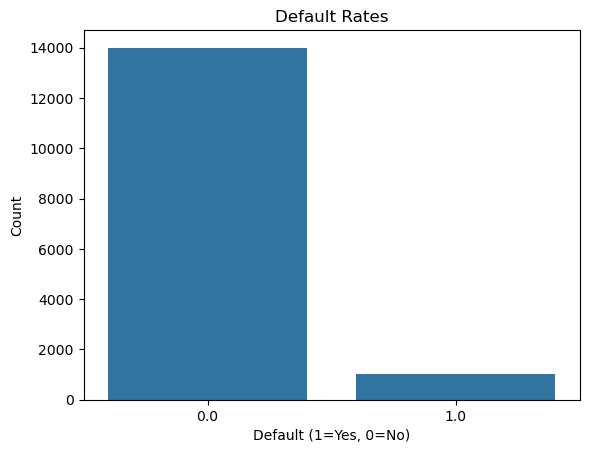

In [10]:
# Plot target feature counts
ax = sns.countplot(imp_data, x='default')
ax.set_title('Default Rates')
ax.set_xlabel('Default (1=Yes, 0=No)')
ax.set_ylabel('Count')

In [11]:
# Calculate the default rate
default_rate = imp_data['default'].mean()
print(f'Default Rate: {default_rate:.1%}')

Default Rate: 6.7%


### Investigate Correlations

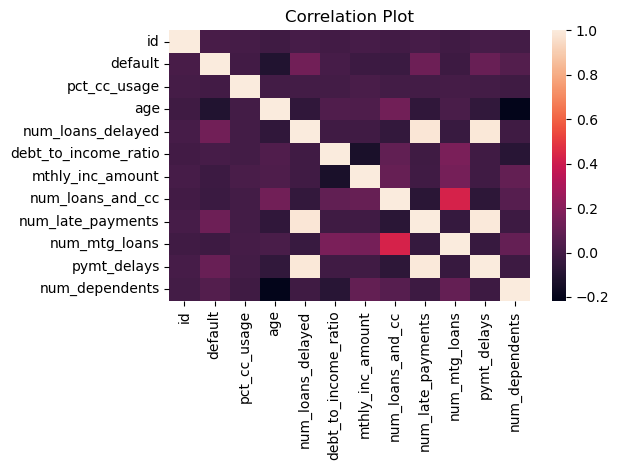

In [12]:
corr = imp_data.corr()
ax = sns.heatmap(corr)
ax.set_title("Correlation Plot")
plt.tight_layout()
plt.savefig('assets/correlation_plot.png')

### Explore and Treat Outliers

Text(0.5, 0.98, 'Distributions by Default')

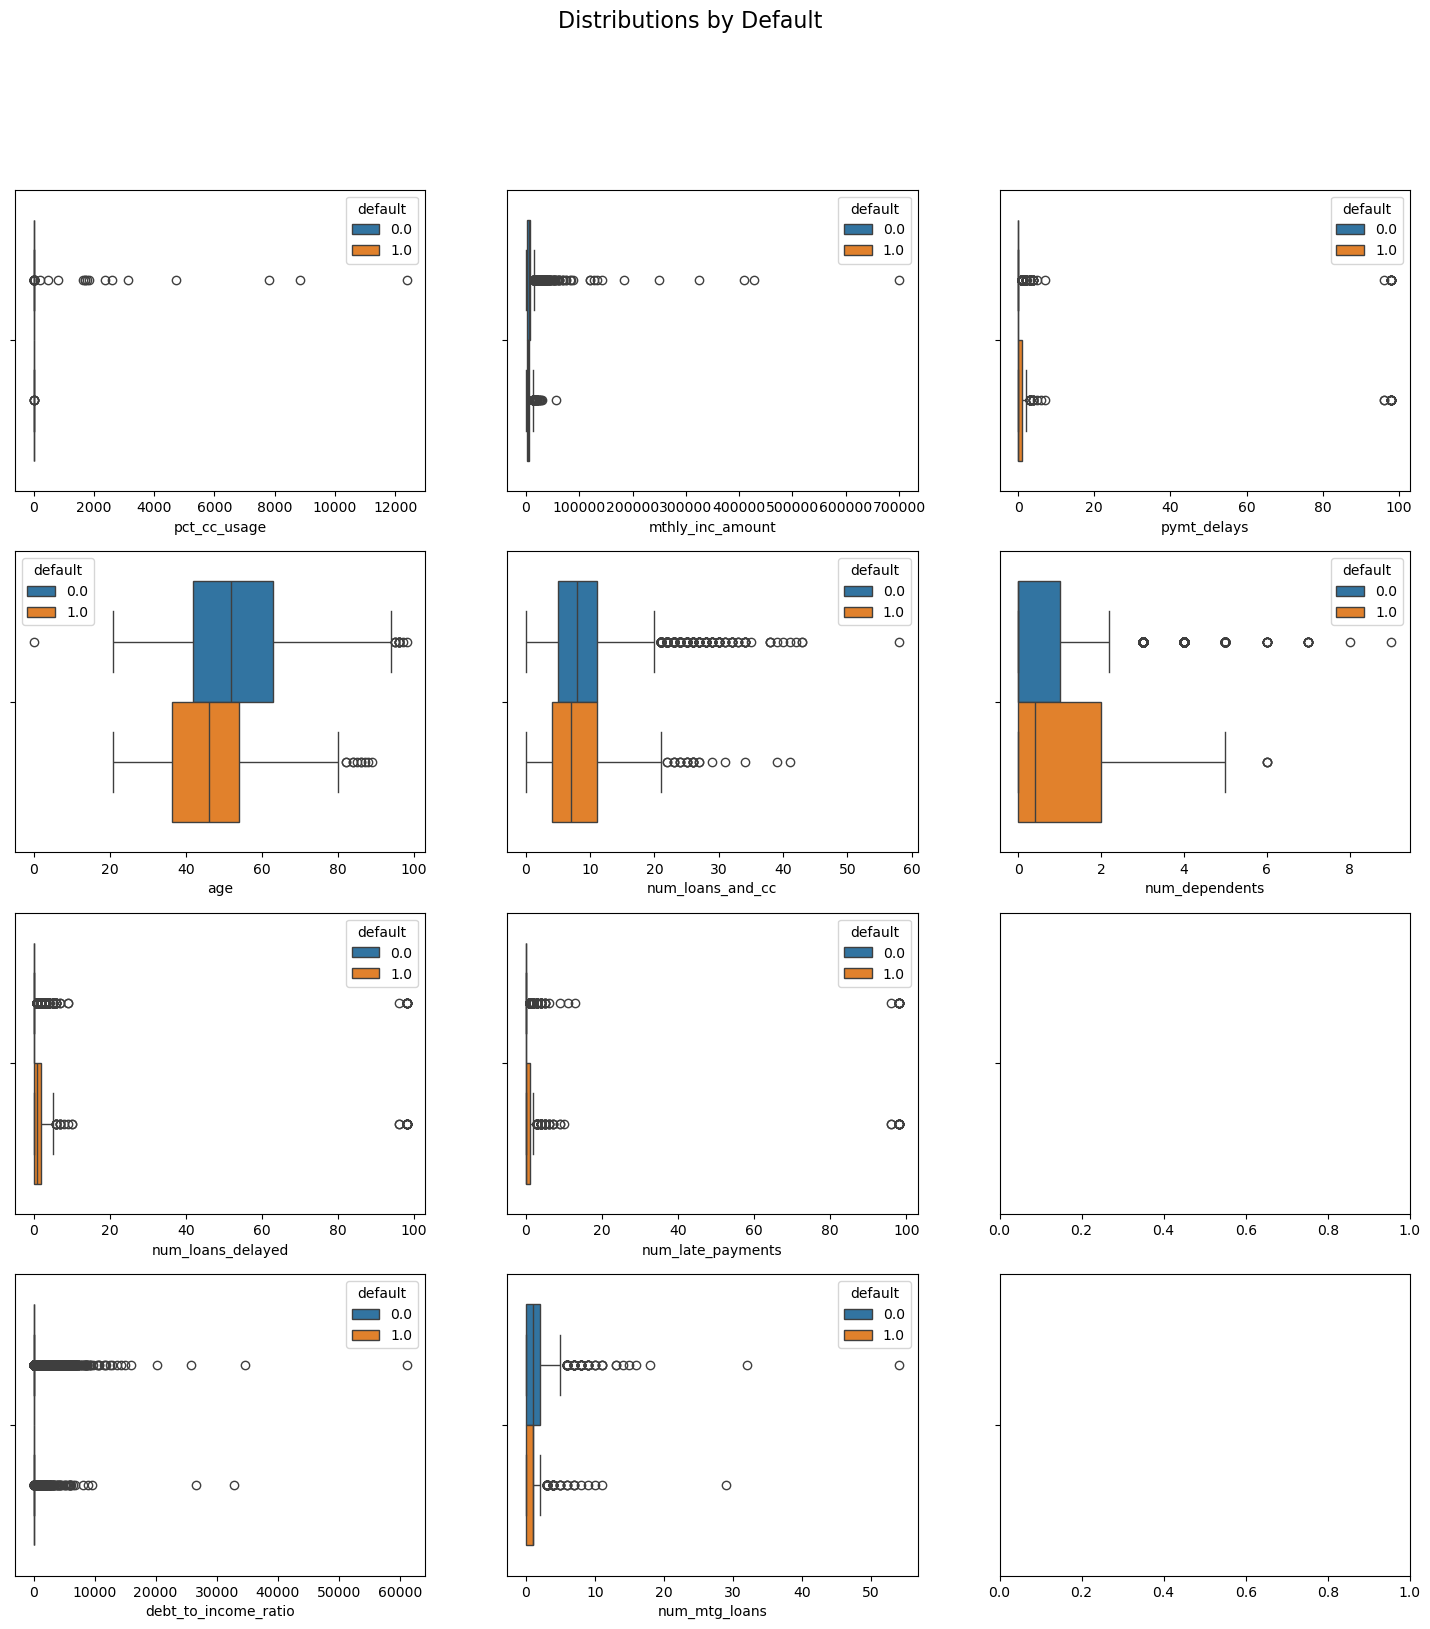

In [13]:
# Look at explanatory feature distributions by the target levels
def dist_charts(data):
    fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(18,18), sharey=True)
    sns.boxplot(data, x='pct_cc_usage', hue='default', ax=axs[0,0])
    sns.boxplot(data, x='age', hue='default', ax=axs[1,0])
    sns.boxplot(data, x='num_loans_delayed', hue='default', ax=axs[2,0])
    sns.boxplot(data, x='debt_to_income_ratio', hue='default', ax=axs[3,0])
    
    sns.boxplot(data, x='mthly_inc_amount', hue='default', ax=axs[0,1])
    sns.boxplot(data, x='num_loans_and_cc', hue='default', ax=axs[1,1])
    sns.boxplot(data, x='num_late_payments', hue='default', ax=axs[2,1])
    sns.boxplot(data, x='num_mtg_loans', hue='default', ax=axs[3,1])
    
    sns.boxplot(data, x='pymt_delays', hue='default', ax=axs[0,2])
    sns.boxplot(data, x='num_dependents', hue='default', ax=axs[1,2])
    return((fig, axs))
    
fig, axs = dist_charts(imp_data)
fig.suptitle('Distributions by Default', fontsize=16)

In [14]:
# Examine a pairplot
# This can take about 30 minutes to run
if include_pairplot == True:
    sns.pairplot(imp_data, hue='default')

In [15]:
# Examine Outliers
clf = IsolationForest(random_state=0).fit(imp_data)
imp_data['outlier_score'] = clf.predict(imp_data)
imp_data['outlier_score'].value_counts()

imp_data.columns

Index(['id', 'default', 'pct_cc_usage', 'age', 'num_loans_delayed',
       'debt_to_income_ratio', 'mthly_inc_amount', 'num_loans_and_cc',
       'num_late_payments', 'num_mtg_loans', 'pymt_delays', 'num_dependents',
       'outlier_score'],
      dtype='object')

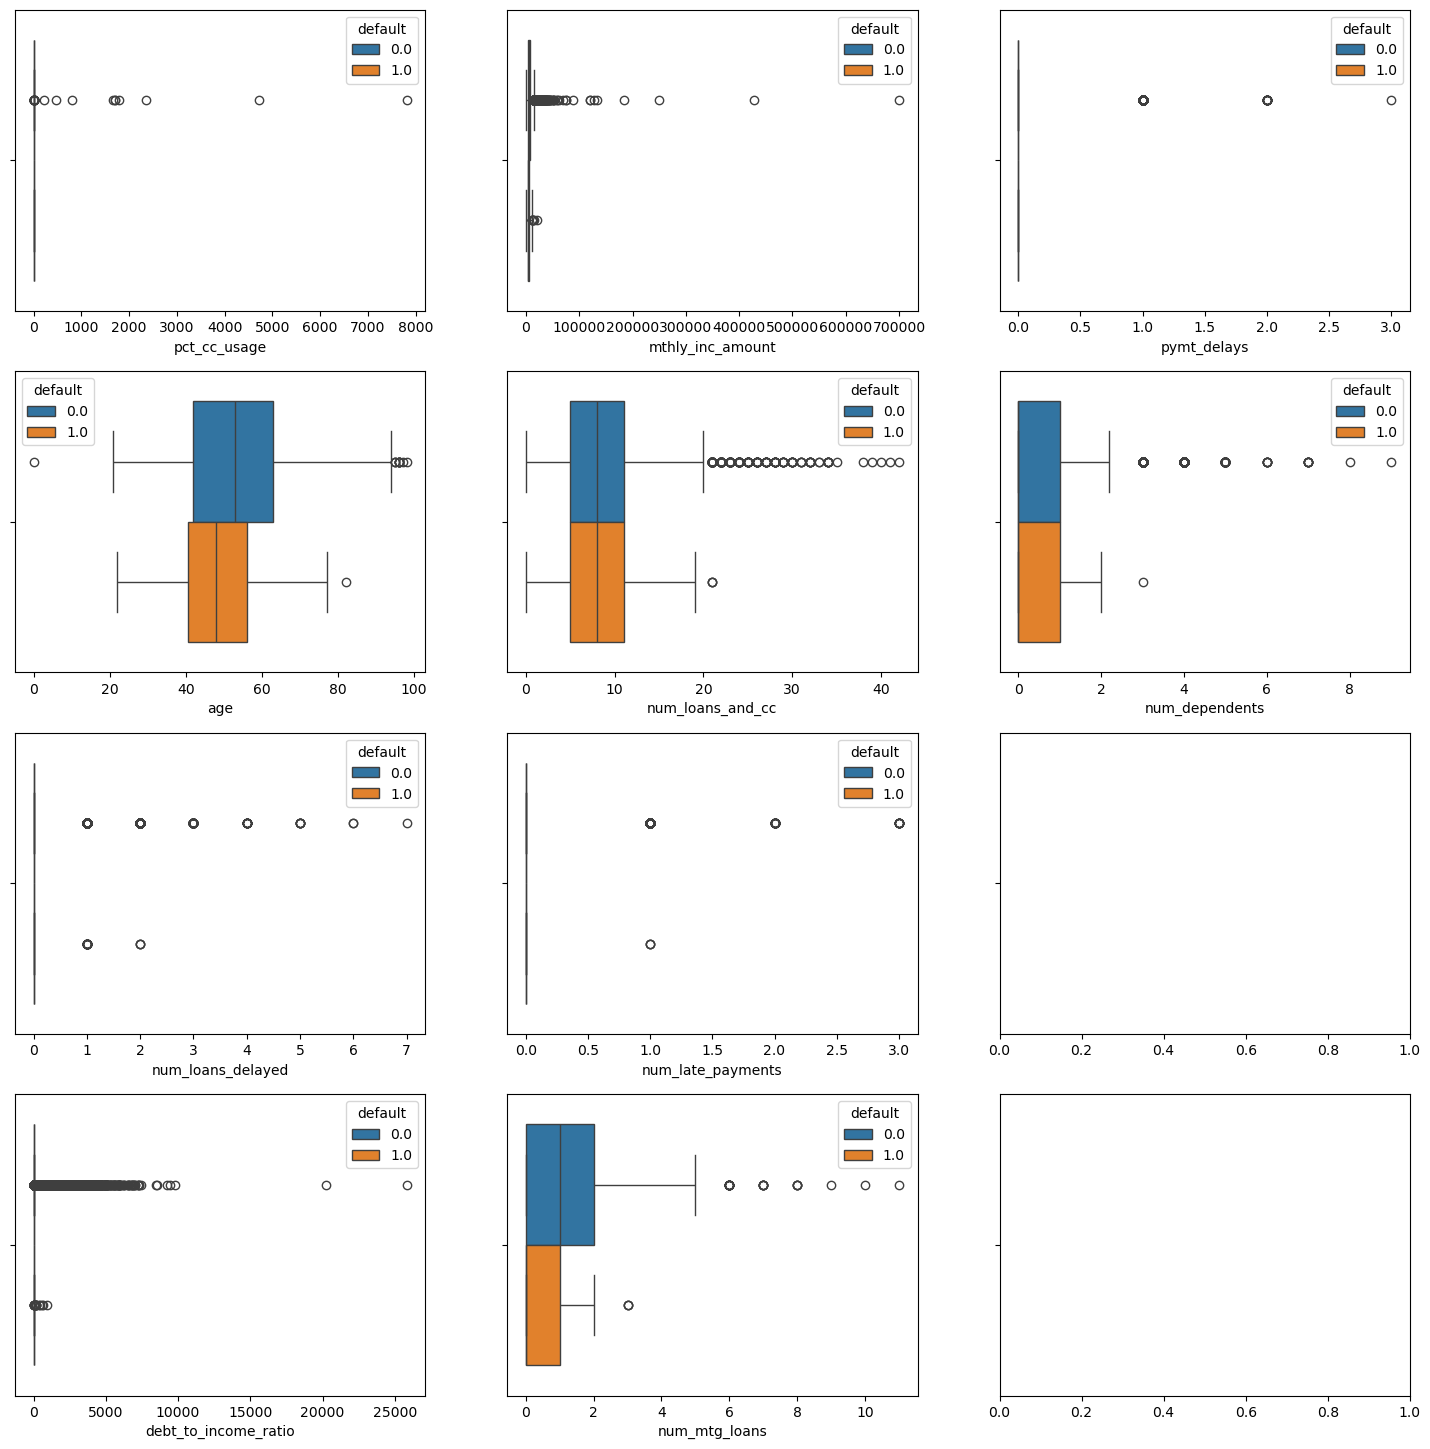

In [16]:
fig, axs = dist_charts(imp_data.query('outlier_score == 1'))

In [17]:
imp_data.columns

Index(['id', 'default', 'pct_cc_usage', 'age', 'num_loans_delayed',
       'debt_to_income_ratio', 'mthly_inc_amount', 'num_loans_and_cc',
       'num_late_payments', 'num_mtg_loans', 'pymt_delays', 'num_dependents',
       'outlier_score'],
      dtype='object')

In [18]:
# Remove outliers and pairplot
imp_no_data = imp_data.query('outlier_score == 1')

if include_pairplot == True:
    sns.pairplot(imp_no_data, hue='default')

## Data Preprocessing


### Drop Unnecessary Columns

In [19]:
# Drop the id column
imp_data = imp_data.drop('id', axis=1)

### Create Training & Test Splits

In [20]:
# Create training and testing datasets
imp_data.columns
X, y = imp_data.drop('default', axis=1), imp_data['default']
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Extract base feature names to list for later use
base_feature_names = list(X.columns)
target_feature_name = y.name

### Create Resampling Training Sets

In [21]:
# Suppress Future Warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Use SMOTE to resample the oversample class
sm = BorderlineSMOTE()
X_train_balanced, y_train_balanced = sm.fit_resample(X_train, y_train)
y_train_balanced.value_counts()

# Restore warnings
warnings.filterwarnings('always', category=FutureWarning)

## Model Building

In [22]:
# Intialize a dictionary to gather modeling results
model_results = {}

### Baseline Model (Dummy Classifier)

Training Set Classification Report - Baseline *******
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     10480
         1.0       0.00      0.00      0.00       770

    accuracy                           0.93     11250
   macro avg       0.47      0.50      0.48     11250
weighted avg       0.87      0.93      0.90     11250

Testing Set Classification Report - Baseline ********
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97      3517
         1.0       0.00      0.00      0.00       233

    accuracy                           0.94      3750
   macro avg       0.47      0.50      0.48      3750
weighted avg       0.88      0.94      0.91      3750



Text(0.5, 0.98, 'Baseline Confusion Matrix')

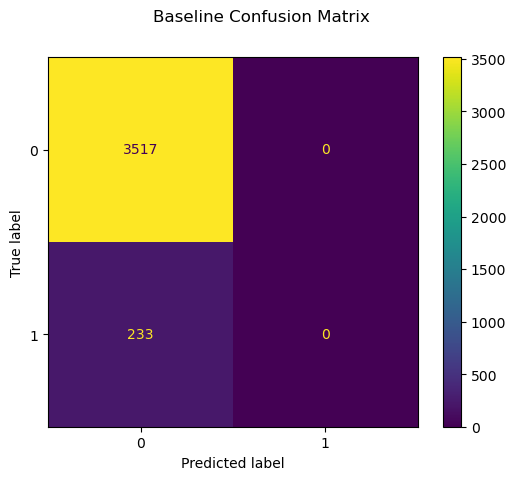

In [23]:
def fit_baseline(X_train, X_test, y_train, y_test, file_name):
    # Ignore warnings
    warnings.filterwarnings('ignore')

    # Create a baseline/naive model
    if read_models == False:
        dummy_clf = DummyClassifier(strategy="most_frequent")
        dummy_clf.fit(X_train, y_train)
    else:
        dummy_clf = joblib.load(file_name)

    # Conditionally save the classifier
    if save_models == True:
        joblib.dump(dummy_clf, file_name)

    # Print classification reports
    print('Training Set Classification Report - Baseline *******')
    print(classification_report(y_train, dummy_clf.predict(X_train)))
    print('Testing Set Classification Report - Baseline ********')
    print(classification_report(y_test, dummy_clf.predict(X_test)))

    # Extract classification reports
    dummy_train_rpt = classification_report(y_train, dummy_clf.predict(X_train), output_dict=True)
    dummy_test_rpt = classification_report(y_test, dummy_clf.predict(X_test), output_dict=True)

    # Restore warnings
    warnings.filterwarnings('always')
    
    # Calculate the confusion matrix
    dummy_cm = confusion_matrix(y_test, dummy_clf.predict(X_test))
    
    return (dummy_train_rpt, dummy_test_rpt, dummy_cm)

# Fit the baseline model
model_results['nosampling_baseline'] = fit_baseline(X_train, X_test, 
                                                    y_train, y_test,
                                                    'models/dummy_classifier.pkl')

# Display baseline results
ConfusionMatrixDisplay(model_results['nosampling_baseline'][2]).plot()
plt.suptitle('Baseline Confusion Matrix\nNo Sampling')

### Logistic Regression

#### Model or Load Logistic Regression Pipeline

/home/jonathan/miniforge3/envs/cc_default/lib/python3.13/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=146258) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/jonathan/miniforge3/envs/cc_default/lib/python3.13/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=146258) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/jonathan/miniforge3/envs/cc_default/lib/python3.13/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=146258) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/jonathan/miniforge3/envs/cc_default/lib/python3.13/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=146258) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.for

Training Set Classification Report - Logistic Reg. **
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98     10480
         1.0       0.64      0.78      0.70       770

    accuracy                           0.95     11250
   macro avg       0.81      0.88      0.84     11250
weighted avg       0.96      0.95      0.96     11250

Testing Set Classification Report - Logistic Reg. **
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98      3517
         1.0       0.60      0.82      0.69       233

    accuracy                           0.96      3750
   macro avg       0.80      0.89      0.83      3750
weighted avg       0.96      0.96      0.96      3750

Training Set Classification Report - Logistic Reg. **
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95     10480
         1.0       0.96      0.93      0.95     10480

    accuracy         

Text(0.5, 0.98, 'Logistic Regression w/ SGD Confusion Matrix\nBorderline SMOTE')

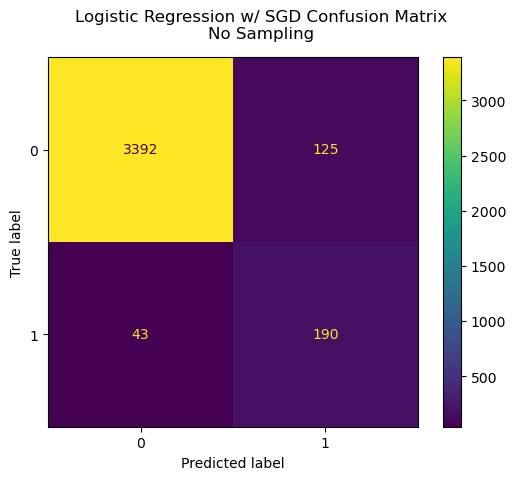

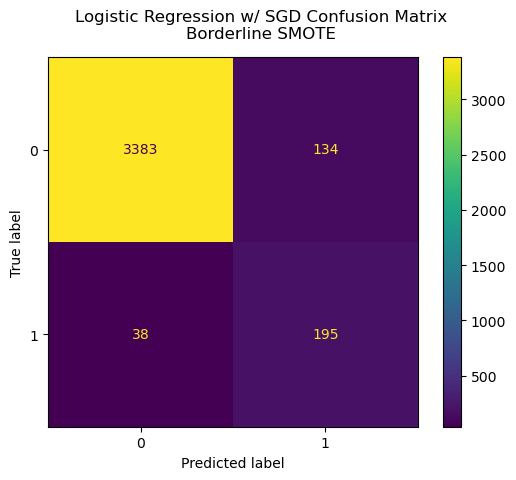

In [25]:
def fit_logistic_w_sgd(X_train, X_test, y_train, y_test, file_name):
    # Restore warnings
    warnings.filterwarnings('always')
    
    # Load or fit model
    if read_models == False:
        lr_pipe = Pipeline([
            ('poly_features', PolynomialFeatures(degree=3, include_bias=False)),
            ('standard_scaler', StandardScaler()),
            ('selector', SequentialFeatureSelector(SGDClassifier(loss='log_loss', n_jobs=-1), 
                                                   n_features_to_select=6,
                                                   n_jobs=-1)),
            ('logistic_regression', SGDClassifier(loss='log_loss', n_jobs=-1,
                                                  max_iter=max_iter))
        ])

        lr_pipe.fit(X_train_balanced, y_train_balanced)

    else:
        lr_pipe = joblib.load(file_name)

    # Conditionally save the model
    if save_models == True:
        joblib.dump(lr_pipe, file_name)

    # Print the classification reports
    print('Training Set Classification Report - Logistic Reg. **')
    print(classification_report(y_train, lr_pipe.predict(X_train)))
    print('Testing Set Classification Report - Logistic Reg. **')
    print(classification_report(y_test, lr_pipe.predict(X_test)))
    

    # Extract classification reports
    lr_train_rpt = classification_report(y_train, lr_pipe.predict(X_train), output_dict=True)
    lr_test_rpt = classification_report(y_test, lr_pipe.predict(X_test), output_dict=True)

    # Restore warnings
    warnings.filterwarnings('always')

    # Calculate the confusion matrix
    lr_cm = confusion_matrix(y_test, lr_pipe.predict(X_test))
    
    return (lr_train_rpt, lr_test_rpt, lr_cm)

# Fit logistic regression model
model_results['nosampling_lr'] = fit_logistic_w_sgd(X_train, X_test, 
                                                    y_train, y_test,
                                                    'models/lr_nosampling_pipe.pkl')
# Display logistic regression results
ConfusionMatrixDisplay(model_results['nosampling_lr'][2]).plot()
plt.suptitle('Logistic Regression w/ SGD Confusion Matrix\nNo Sampling')

# Fit logistic regression model
model_results['borderlineSMOTE_lr'] = fit_logistic_w_sgd(X_train_balanced, X_test, 
                                                         y_train_balanced, y_test,
                                                         'models/lr_borderlineSMOTE_pipe.pkl')
# Display logistic regression results
ConfusionMatrixDisplay(model_results['borderlineSMOTE_lr'][2]).plot()
plt.suptitle('Logistic Regression w/ SGD Confusion Matrix\nBorderline SMOTE')

### Decision Tree

Training Set Classification Report - Decision Tree **
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97     10480
         1.0       0.59      0.80      0.68       770

    accuracy                           0.95     11250
   macro avg       0.79      0.88      0.82     11250
weighted avg       0.96      0.95      0.95     11250

Testing Set Classification Report - Decision Tree ***
              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97      3517
         1.0       0.55      0.83      0.66       233

    accuracy                           0.95      3750
   macro avg       0.77      0.89      0.82      3750
weighted avg       0.96      0.95      0.95      3750

Training Set Classification Report - Decision Tree **
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96     10480
         1.0       0.96      0.96      0.96     10480

    accuracy        

Text(0.5, 0.98, 'Decision Tree Confusion Matrix\nBorderline SMOTE')

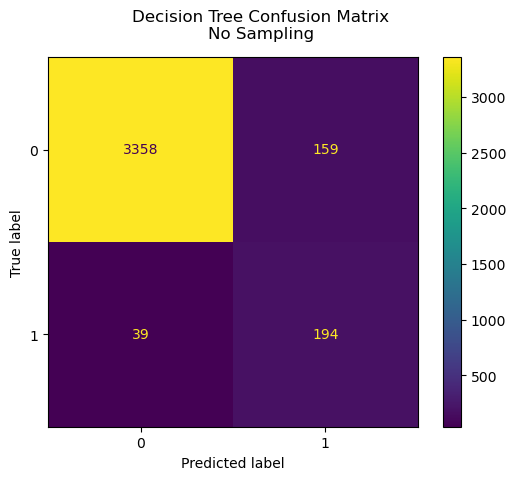

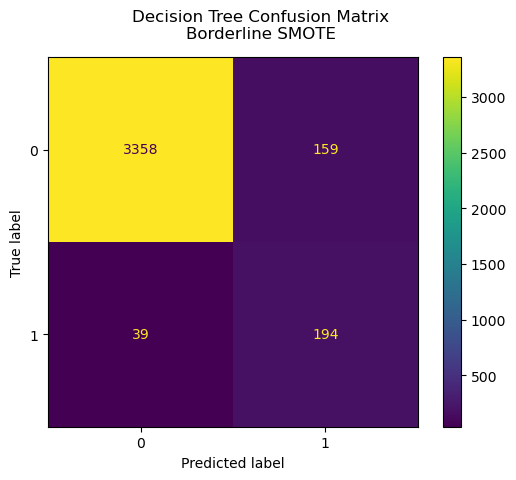

In [29]:
def fit_decision_tree(X_train, X_test, y_train, y_test, file_name):

    # Implement a decision tree using gridCV
    if read_models == False:
        # Parameters for the GridSearch
        params = {'min_impurity_decrease': [0.001, 0.01, 0.02, 0.03, 0.05],
                  'max_depth': [2, 5, 10],
                  'min_samples_split': [0.1, 0.2, 0.05],
                  'criterion': ['gini', 'entropy']}

        dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=rand_state),
                               param_grid=params,
                               scoring='recall').fit(X_train_balanced, y_train_balanced)
    else:
        dt_grid = joblib.load(file_name)

    if save_models == True:
        joblib.dump(dt_grid, file_name)

    # Print the classification reports
    print('Training Set Classification Report - Decision Tree **')
    print(classification_report(y_train, dt_grid.predict(X_train)))
    print('Testing Set Classification Report - Decision Tree ***')
    print(classification_report(y_test, dt_grid.predict(X_test)))

    # Extract classification reports
    dt_train_rpt = classification_report(y_train, dt_grid.predict(X_train), output_dict=True)
    dt_test_rpt = classification_report(y_test, dt_grid.predict(X_test), output_dict=True)
    
    # Calculate the confusion matrix
    dt_cm = confusion_matrix(y_test, dt_grid.predict(X_test))
    
    return (dt_train_rpt, dt_test_rpt, dt_cm)

# Fit decision tree model
model_results['nosampling_dt'] = fit_decision_tree(X_train, X_test, 
                                                   y_train, y_test,
                                                  'models/dt_nosampling_classifier.pkl')

# Display decision tree results
ConfusionMatrixDisplay(model_results['nosampling_dt'][2]).plot()
plt.suptitle('Decision Tree Confusion Matrix\nNo Sampling')

# Fit decision tree model
model_results['borderlineSMOTE_dt'] = fit_decision_tree(X_train_balanced, X_test, 
                                                        y_train_balanced, y_test,
                                                        'models/dt_borderlineSMOTE_classifier.pkl')

# Display decision tree results
ConfusionMatrixDisplay(model_results['borderlineSMOTE_dt'][2]).plot()
plt.suptitle('Decision Tree Confusion Matrix\nBorderline SMOTE')

### Random Forest

Training Set Classification Report - Random Forest **
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10480
         1.0       1.00      1.00      1.00     10480

    accuracy                           1.00     20960
   macro avg       1.00      1.00      1.00     20960
weighted avg       1.00      1.00      1.00     20960

Testing Set Classification Report - Random Forest ***
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      3517
         1.0       0.69      0.75      0.72       233

    accuracy                           0.96      3750
   macro avg       0.84      0.86      0.85      3750
weighted avg       0.97      0.96      0.96      3750

Training Set Classification Report - Random Forest **
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10480
         1.0       1.00      1.00      1.00     10480

    accuracy        

Text(0.5, 0.98, 'Random Forest Confusion Matrix\nBorderline SMOTE')

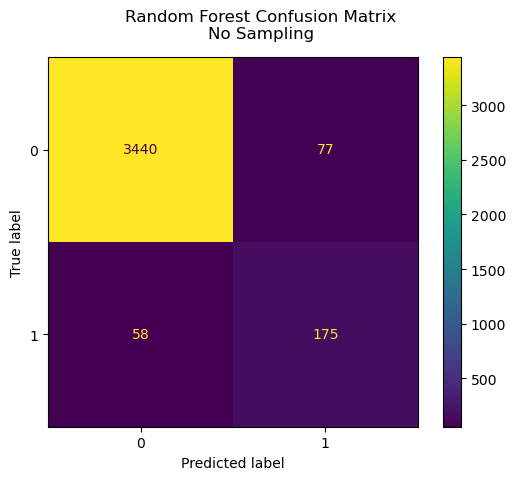

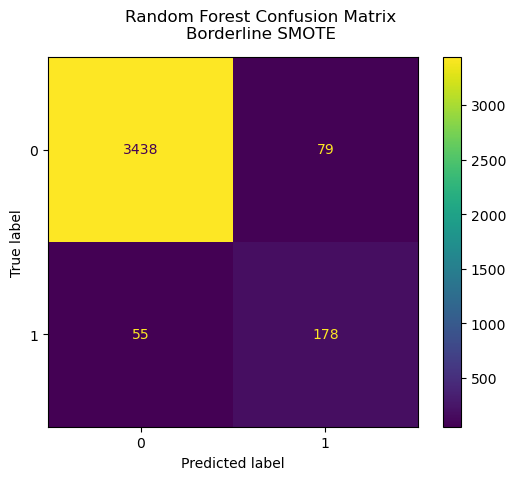

In [31]:

def fit_random_forest(X_train, X_test, y_train, y_test, file_name):
    if read_models == False:
        rf_clf = RandomForestClassifier().fit(X_train_balanced, y_train_balanced)
    else:
        rf_clf = joblib.load(file_name)

    if save_models == True:
        joblib.dump(rf_clf, file_name)

    # Print the classification reports
    print('Training Set Classification Report - Random Forest **')
    print(classification_report(y_train, rf_clf.predict(X_train)))
    print('Testing Set Classification Report - Random Forest ***')
    print(classification_report(y_test, rf_clf.predict(X_test)))
    
    # Calculate the confusion matrix
    rf_cm = confusion_matrix(y_test, rf_clf.predict(X_test))

    # Extract classification reports
    rf_train_rpt = classification_report(y_train, rf_clf.predict(X_train), output_dict=True)
    rf_test_rpt = classification_report(y_test, rf_clf.predict(X_test), output_dict=True) 
    
    return (rf_train_rpt, rf_test_rpt, rf_cm)

model_results['nosampling_rf'] = fit_random_forest(X_train_balanced, X_test, 
                                                        y_train_balanced, y_test,
                                                        'models/rf_nosampling_classifier.pkl')

# Plot the confusion matrix
ConfusionMatrixDisplay(model_results['nosampling_rf'][2]).plot()
plt.suptitle('Random Forest Confusion Matrix\nNo Sampling')

model_results['borderlineSMOTE_rf'] = fit_random_forest(X_train_balanced, X_test, 
                                                        y_train_balanced, y_test,
                                                        'models/rf_borderlineSMOTE_classifier.pkl')

# Plot the confusion matrix
ConfusionMatrixDisplay(model_results['borderlineSMOTE_rf'][2]).plot()
plt.suptitle('Random Forest Confusion Matrix\nBorderline SMOTE')

## Evaluation

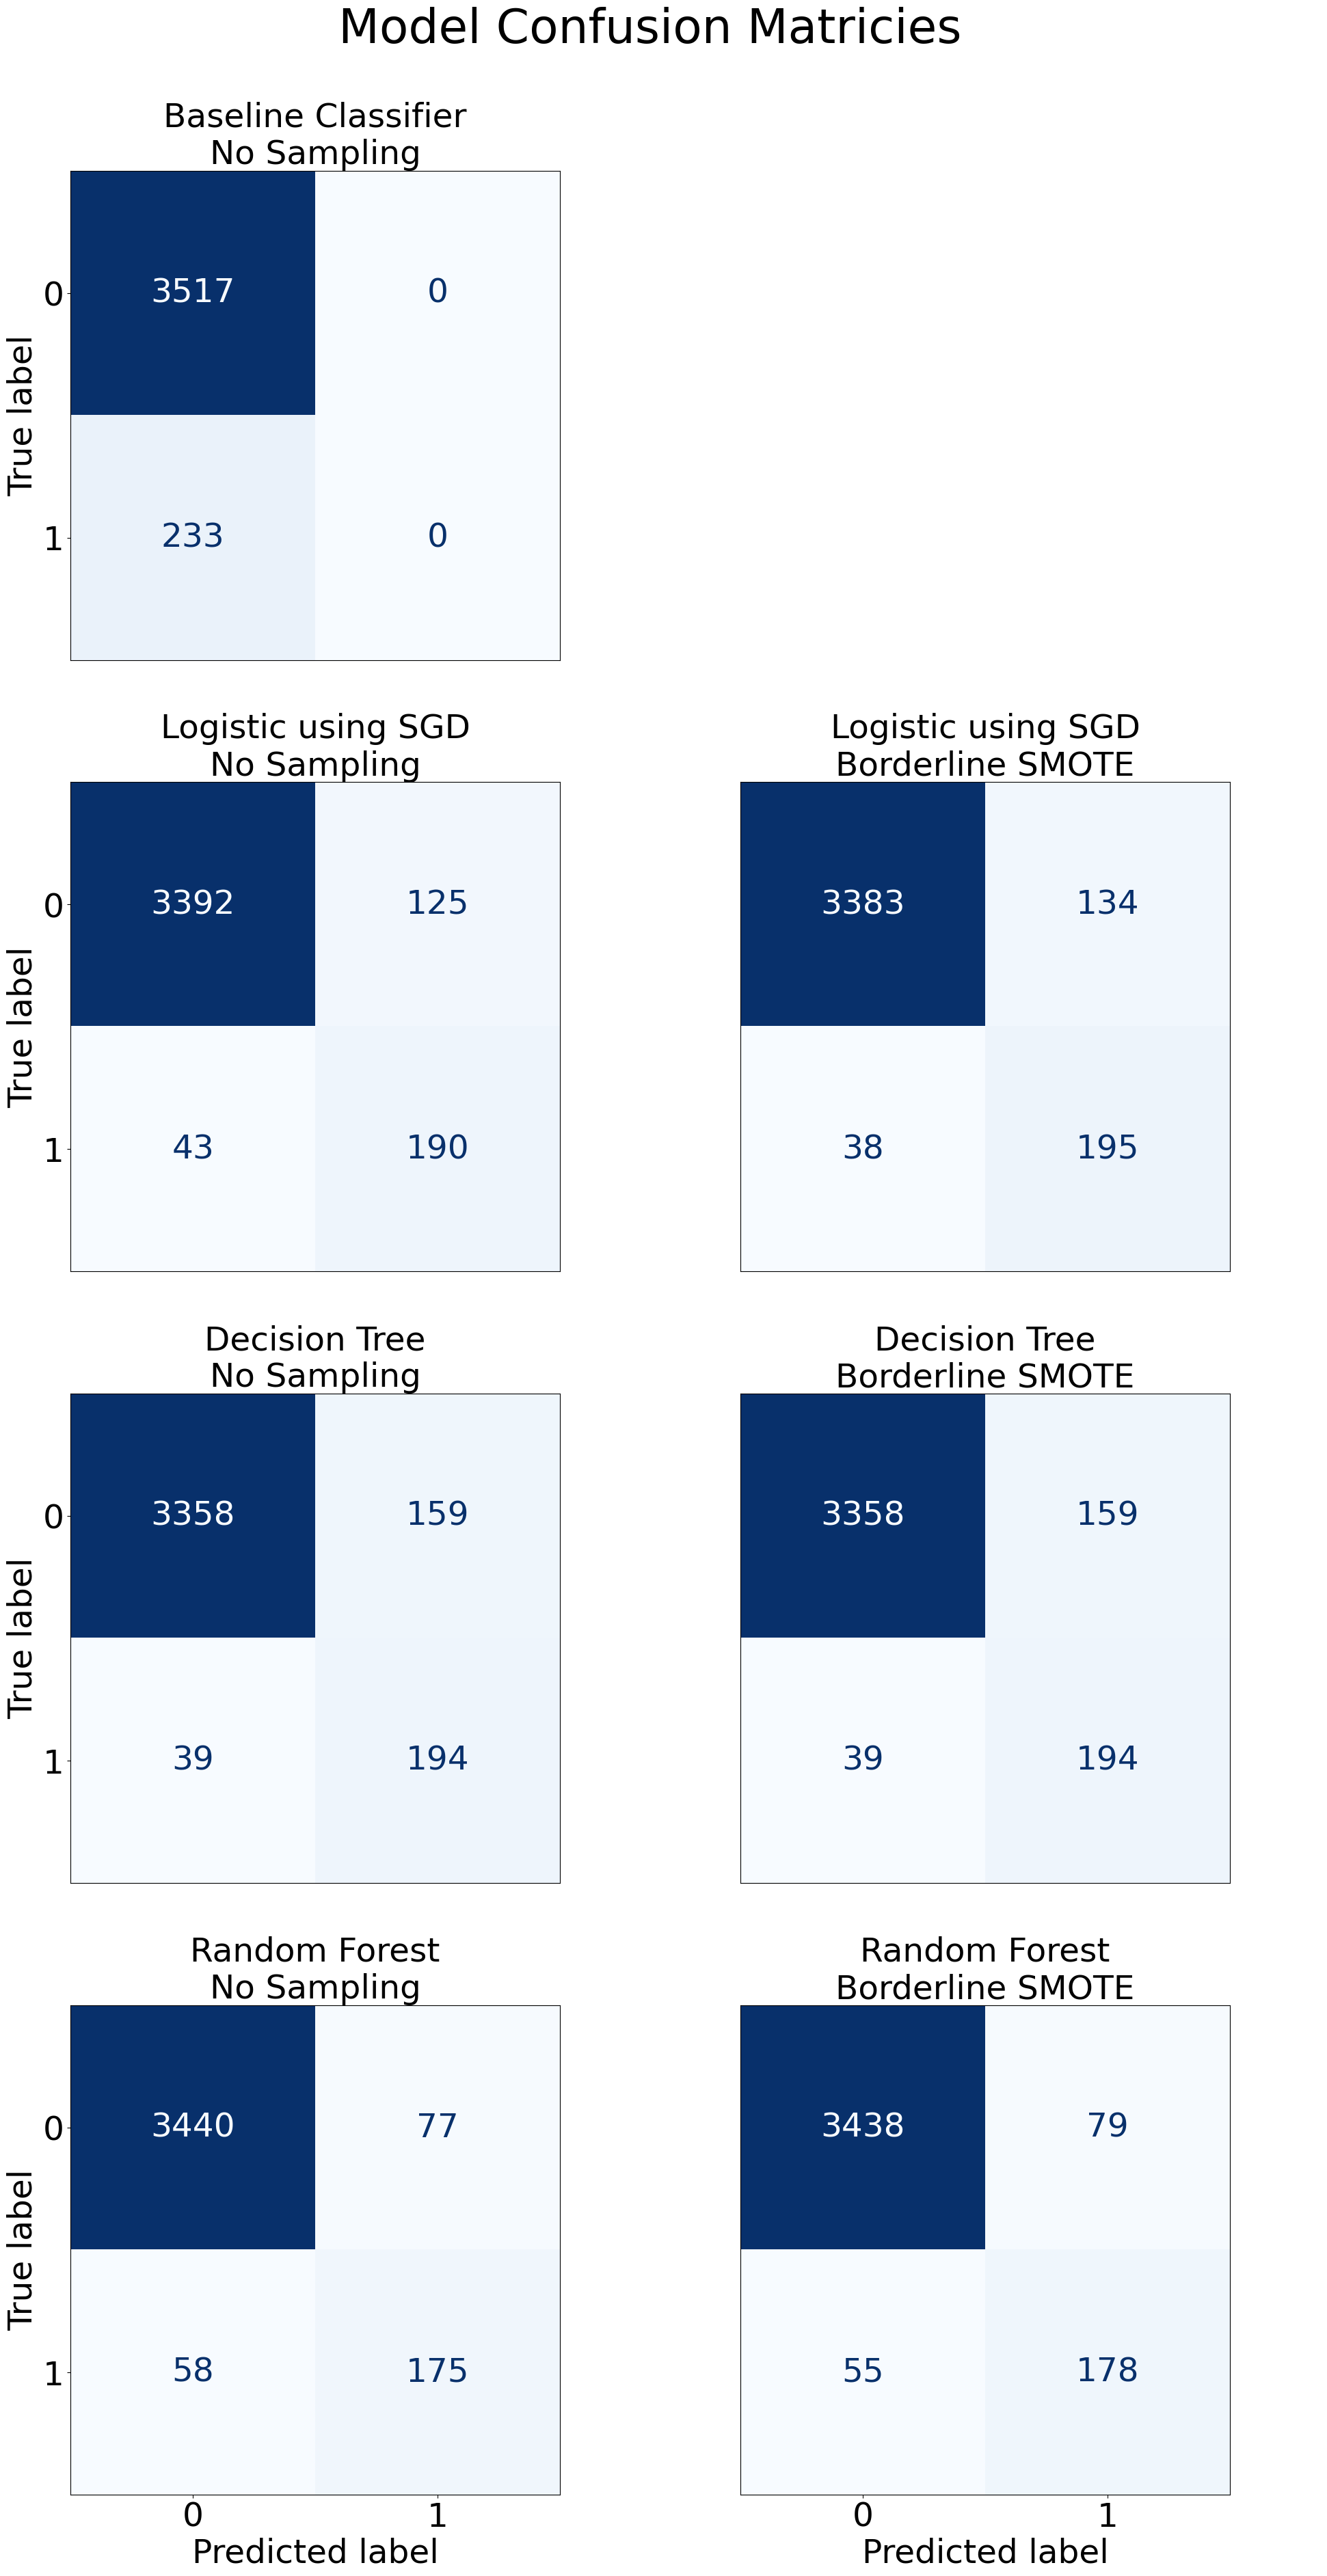

In [98]:
################################################################################
# Create an export a combined confusion matrix plot
################################################################################
# Set graph specific parameters
label_size = 35
title_size = 50
colorbar = False
cmap = 'Blues'

# Set global options and create subplot
plt.rcParams.update({'font.size':label_size})
fig, axes = plt.subplots(4, 2, figsize=(20,40))
fig.suptitle('Model Confusion Matricies', y=.96, size=title_size)
plt.subplots_adjust(left=.01, right=.99, wspace=0,
                    bottom=.05, top=.9, hspace=.25)

# Plot on Axis [0,0]
ConfusionMatrixDisplay(model_results['nosampling_baseline'][2]).plot(ax=axes[0,0], colorbar=colorbar, cmap=cmap)
axes[0,0].set_title('Baseline Classifier\nNo Sampling', size=label_size)
axes[0,0].set_xlabel('')
axes[0,0].tick_params(bottom=False, labelbottom=False)

# Remove plot on Axis [0,1]
axes[0,1].get_xaxis().set_visible(False)
axes[0,1].get_yaxis().set_visible(False)
axes[0,1].spines['top'].set_visible(False)
axes[0,1].spines['bottom'].set_visible(False)
axes[0,1].spines['left'].set_visible(False)
axes[0,1].spines['right'].set_visible(False)


# Plot on Axis [1,0]
ConfusionMatrixDisplay(model_results['nosampling_lr'][2]).plot(ax=axes[1,0], colorbar=False, cmap=cmap)
axes[1,0].set_title('Logistic using SGD\nNo Sampling', size=label_size)
axes[1,0].set_xlabel('')
axes[1,0].tick_params(bottom=False, labelbottom=False)

# Plot on Axis [1,1]
ConfusionMatrixDisplay(model_results['borderlineSMOTE_lr'][2]).plot(ax=axes[1,1], colorbar=False, cmap=cmap)
axes[1,1].set_title('Logistic using SGD\nBorderline SMOTE', size=label_size)
axes[1,1].set_xlabel('')
axes[1,1].set_ylabel('')
axes[1,1].tick_params(bottom=False, labelbottom=False,
                      left=False, labelleft=False)

# Plot on Axis [2,0]
ConfusionMatrixDisplay(model_results['nosampling_dt'][2]).plot(ax=axes[2,0], colorbar=False, cmap=cmap)
axes[2,0].set_title('Decision Tree\nNo Sampling', size=label_size)
axes[2,0].set_xlabel('')
axes[2,0].tick_params(bottom=False, labelbottom=False)

# Plot on Axis [2,1]
ConfusionMatrixDisplay(model_results['borderlineSMOTE_dt'][2]).plot(ax=axes[2,1], colorbar=False, cmap=cmap)
axes[2,1].set_title('Decision Tree\nBorderline SMOTE', size=label_size)
axes[2,1].set_xlabel('')
axes[2,1].set_ylabel('')
axes[2,1].tick_params(left=False, labelleft=False,
                      bottom=False, labelbottom=False)

# Plot on Axis [3,0]
ConfusionMatrixDisplay(model_results['nosampling_rf'][2]).plot(ax=axes[3,0], colorbar=False, cmap=cmap)
axes[3,0].set_title('Random Forest\nNo Sampling', size=label_size)

# Plot on Axis [3,1]
ConfusionMatrixDisplay(model_results['borderlineSMOTE_rf'][2]).plot(ax=axes[3,1], colorbar=False, cmap=cmap)
axes[3,1].set_title('Random Forest\nBorderline SMOTE', size=label_size)
axes[3,1].set_ylabel('')
axes[3,1].tick_params(left=False, labelleft=False)

# Save plot
plt.savefig('assets/models_cm.png')

In [ ]:
################################################################################
# Create Performance Metrics Table from Classification Reports
################################################################################

warnings.filterwarnings('ignore', category=DeprecationWarning)

def model_metrics_df(class_rpt, model_nm, train=True):
    if train == True:
        set_type = ['Train, Class 0', 'Train, Class 1']
    else:
        set_type = ['Test, Class 0', 'Test, Class 1']
    
    return pd.DataFrame({'Model':[model_nm, model_nm],
                         'Set Type, Class':set_type,
                         'Precision':[class_rpt['0.0']['precision'],
                                      class_rpt['1.0']['precision']],
                         'Recall':[class_rpt['0.0']['recall'],
                                      class_rpt['1.0']['recall']],
                         'F1-score':[class_rpt['0.0']['f1-score'],
                                      class_rpt['1.0']['f1-score']],
                         'Support':[class_rpt['0.0']['support'],
                                      class_rpt['1.0']['support']],
                         'Accuracy':[class_rpt['accuracy'], np.nan]})

pf_metrics_tab = pd.concat([model_metrics_df(model_results['nosampling_baseline'][0], 'Baseline'),
                            model_metrics_df(model_results['nosampling_baseline'][1], 'Baseline', train=False),
                            model_metrics_df(model_results['borderlineSMOTE_lr'][0], 'Logistic w/ SGD'),
                            model_metrics_df(model_results['borderlineSMOTE_lr'][1], 'Logistic w/ SGD', train=False),
                            model_metrics_df(model_results['borderlineSMOTE_dt'][0], 'Decision Tree'),
                            model_metrics_df(model_results['borderlineSMOTE_dt'][1], 'Decision Tree', train=False),
                            model_metrics_df(model_results['borderlineSMOTE_rf'][0], 'Random Forest'),
                            model_metrics_df(model_results['borderlineSMOTE_rf'][1], 'Random Forest', train=False)])

summary_table = (GT(pf_metrics_tab)
 .fmt_number(columns=['Precision', 'Recall', 'F1-score', 'Accuracy'], decimals=3)
 .fmt_number(columns=['Support'], decimals=0)
 .tab_stub(rowname_col='Set Type, Class', groupname_col='Model')
 .tab_header(title='Performance Metrics by Model')
 .opt_stylize(style=1, color='blue')
 )

summary_table.show()

summary_table.save('assets/performance_metrics_table.png')

# Turn deprecation warnings back on
warnings.filterwarnings('always', category=DeprecationWarning)


## References

***Quiroz, H. F. (2024). credit default only numeric data. Kaggle.com. https://www.kaggle.com/datasets/hugoferquiroz/credit-default-only-numbers**

## Questions
- Should I sample for a decision tree or random forest model?
- I believe that I want to maximize the Recall (true positive rate)
- How should I eliminate the convergence errors